# BELGIAN EATING HABITS

## SPARK - Group Assignment
## Team B

# Table of Contents

* [1. Pyspark enviroment setup](#1)
* [2. Data source and Spark data abstraction (DataFrame) setup](#2)
* [3. Dataset exploration](#3)
* [4. Business Questions](#4)
 * [4.1. Find the oldest product](#4.1.)
 * [4.2. Find the newest product](#4.2.)
 * [4.3. Average product age](#4.3.)
 * [4.4. List of other countries where products are sold too](#4.4.)
 * [4.5. Identify category of products and the compute](#4.5.)
     * [4.5.1. Number of products by category](#4.5.1.)
     * [4.5.2. List containing names of products by category](#4.5.2.)     
 * [4.6. Identify traces and compute](#4.6.)
     * [4.6.1. Number of products by trace](#4.6.1.)
     * [4.6.2. List containing names of products by traces](#4.6.2.)    
 * [4.7. Data quality analysis on fields of interest](#4.7.)
     * [4.7.1. Number of products with complete info](#4.7.1.)
     * [4.7.2. % of products without complete analysis per 100g](#4.7.2.)
     * [4.7.3. % of products without additives info](#4.7.3.)
     * [4.7.4. % of products without traces info](#4.7.4.)     
 * [4.8. Data profiling on fields of interest](#4.8.)
* [5. Healthy products Analysis](#5)


In [ ]:
import sys
!{sys.executable} -m pip install StringIO

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 14px; }</style>")) # Increase font size

## 1. Pyspark enviroment setup
<a id='1'></a>

In [110]:
import findspark
findspark.init()

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

from IPython.display import display, Markdown
from pyspark.sql.functions import when, count, col, countDistinct, desc, first, lit, sum, count, round, explode, split, regexp_extract, isnan, countDistinct, avg, collect_list, expr
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.sql.window import Window
from functools import reduce

import PIL.Image
#from PIL import Image
import requests

#libraries to implement the charts
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from IPython.display import Image


sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## 2. Data source and Spark data abstraction (DataFrame) setup
<a id='2'></a>

In [165]:
df = spark.read \
                 .option("inferSchema", "true") \
                 .option("header", "true") \
                 .option("multiline", "true") \
                 .option("quote", '"') \
                 .option("delimiter", ',') \
                 .option("escape", "\\") \
                 .option("escape", '"') \
                 .csv("en.openfoodfacts.org.products.Belgium.csv")

## 3. Dataset exploration
<a id='3'></a>

In [4]:
df.printSchema()
display(Markdown("This DataFrame has **%d rows**." % df.count()))

root
 |-- code: double (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: integer (nullable = true)
 |-- created_datetime: timestamp (nullable = true)
 |-- last_modified_t: integer (nullable = true)
 |-- last_modified_datetime: timestamp (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (n

This DataFrame has **51797 rows**.

In [5]:
df.cache() # optimization to make the processing faster
df.sample(False, 0.1).show(n=2, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 code                                       | 1518.0                                                                                                                                                                                                                                                                                                                                                                                     
 url                                        | http://world-en.openfoodfacts.org/product/000000001518/confiture-artisanale-de-raphael                

Given that the field Product_name is one the on the most important fields we are going to base our analysis on, it doesn't makes sense to have Null product names in the dataset, so we drop them 

In [166]:
display(df.filter(col('Product_Name').isNull()).count())

1568

In [167]:
df = df.dropna(subset=('Product_name'))

The '-' sign can give us some problems when doing column wise calculations, so we rename some columns to avoid this issue

In [168]:
df = df.withColumnRenamed('Energy-kcal_100g', 'Energy_kcal_100g')\
       .withColumnRenamed('Saturated-fat_100g', 'Saturated_fat_100g')

We create the summarized dataset with the fields of interest

In [169]:
df_sum = df.select('Creator',
'Created_datetime',
'Last_modified_datetime',
'code',                          
'Product_name',
'Countries_en',
'Traces_en',
'Additives_tags',
'Main_category_en',
'Image_url',
'Quantity',
'Packaging_tags',
'Categories_en',
'Ingredients_text',
'Additives_en',
'Energy_kcal_100g',
'Fat_100g',
'Saturated_fat_100g',
'Sugars_100g',
'Salt_100g',
'sodium_100g')

## 4. Business Questions
<a id='4'></a>

### 4.1. Find the oldest product
<a id='4.1.'></a>

In [10]:
pd.set_option('display.max_colwidth', 200)
df.select('Product_name','Created_datetime','creator','categories').orderBy('Created_datetime').limit(1).toPandas()

,Product_name,Created_datetime,creator,categories
0,Lulu La Barquette Fraise,2012-02-11 16:07:23,marianne,"Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits, Barquettes aux fruits, Biscuits à la fraise, Barquettes à la fraise"


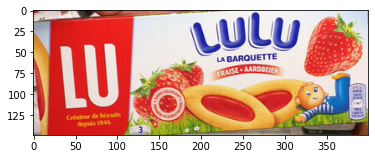

In [11]:
url = df.select('image_url').orderBy('Created_datetime').limit(1).collect()[0]['image_url']

response = requests.get(url, stream=True)
img = PIL.Image.open(response.raw)

plt.imshow(img)
plt.show()

### 4.2. Find the newest product
<a id='4.2.'></a>

In [12]:
df.select('Product_name','Created_datetime','categories').orderBy('Created_datetime', ascending=False).limit(1).toPandas()

,Product_name,Created_datetime,categories
0,Andalouse,2020-09-13 03:23:53,None


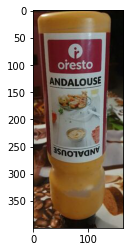

In [13]:
url = df.select('image_url').orderBy('Created_datetime', ascending=False).limit(1).collect()[0]['image_url']

response = requests.get(url, stream=True)
img = PIL.Image.open(response.raw)


plt.imshow(img)
plt.show()

### 4.3. Average product age
<a id='4.3.'></a>

where age means how long the product has been in the system

In [14]:
#Set a fix date corresponding to the presentation date
duedate = datetime.date(2020, 10, 16)

# Add a column with the days since created
df = df.withColumn('days_since_created', f.datediff(f.lit(duedate), col('created_datetime')))
df.select('Product_name','days_since_created').show(1)

+--------------------+------------------+
|        Product_name|days_since_created|
+--------------------+------------------+
|Confiture artisan...|               370|
+--------------------+------------------+
only showing top 1 row



In [16]:
# take the average of the new column created

df.agg(avg(col("days_since_created"))).show()

+-----------------------+
|avg(days_since_created)|
+-----------------------+
|      665.7428178940453|
+-----------------------+



### 4.4. List of other countries where products are sold too.
<a id='4.4.'></a>

In [51]:
# Explore field Countries_en
countriesDF = df.select('Product_name',"countries_en").distinct()  

display(Markdown("There are **%d** distinct combinations of countries, being some of them:" % countriesDF.distinct().count()))

countriesDF.select('countries_en').distinct().show(truncate=100)

There are **41447** distinct combinations of countries, being some of them:

+----------------------------------------------------------------------------------------------------+
|                                                                                        countries_en|
+----------------------------------------------------------------------------------------------------+
|Canada,Germany,Italy,United States,Argentina-espanol,Armenia-pyсский,Aruba-espanol,Asia-pacific,A...|
|                                                                          Belgium,Norway,Switzerland|
|                                                                                     Belgium,Denmark|
|   Algeria,Belgium,Croatia,Czech Republic,France,Morocco,Poland,Réunion,Romania,Slovakia,Switzerland|
|                                           Belgium,France,Germany,Luxembourg,Netherlands,Switzerland|
|                                      Belgium,Denmark,France,Germany,Italy,Norway,Sweden,Switzerland|
|                               Austria,Belgium,Denmark,France,Germany,Ne

In [52]:
# Convert string to list-like array
countriesDF = countriesDF.withColumn('countries', split(countriesDF['countries_en'], ','))

# Explode the values into new records
ex_df = countriesDF.withColumn('ex_countries', explode(countriesDF['countries']))

# Inspect the values
display(Markdown("There are **%d** distinct countries, being some of them:" % ex_df[["ex_countries"]].distinct().count()))

ex_df[['ex_countries']].distinct().show(100, truncate=50)

There are **228** distinct countries, being some of them:

+--------------------------------+
|                    ex_countries|
+--------------------------------+
|                   Côte d'Ivoire|
|              Middle-east-africa|
|          Czech-republic-čeština|
|                 Greece-ελληνικά|
|                          Russia|
|                  Hungary-magyar|
|                  Romania-romană|
|                  Hong-kong-粵語|
|                   Malaysia-中文|
|                         Senegal|
|                          Sweden|
|                         it:asia|
|                          Jersey|
|             New-zealand-english|
|                  Russia-русский|
|                       Singapore|
|                        Malaysia|
|                Malaysia-english|
|                          Turkey|
|              Costa-rica-espanol|
|                   Moldova-roman|
|                     fr:tyskland|
|                 Cyprus-ελληνικά|
|                it:smart-working|
|                         Germany|
|                       

##### As trying to separate out the actual list of countries from the mess that is being shown, we re-examined the original list of columns from the data and noticed that there is a column "countries". The analysis so far for the list of countries has been based on the column "countries_en" which was listed as a field of interest in the assignment instructions. Now we will redo the analysis with the "countries" column

In [53]:
countriesDF2 = df.select("countries").distinct()

display(Markdown("There are **%d** distinct combinations of countries, being some of them:" % countriesDF2.distinct().count()))

countriesDF2.show(truncate=100)

There are **1465** distinct combinations of countries, being some of them:

+------------------------------------------------------------------------+
|                                                               countries|
+------------------------------------------------------------------------+
|                              France,Allemagne,Portugal,Espagne,Belgique|
|                                           Bélgica,España,Estados Unidos|
|                      Frankrijk,Italië,Nederland,Zwitserland, en:belgium|
|                                 Belgique,France,Allemagne,Italie,Suisse|
|                                       Belgium, Finland, France, Germany|
|                                                          Belgium, India|
|                                                         Belgio,en:italy|
|                                                           België,Spanje|
|                                                          Belgium, en:de|
|                                     Belgique,France,Allemagne,en:france|
|                        

In [54]:
# Convert string to list-like array
countriesDF2 = countriesDF2.withColumn('countries', split(countriesDF2['countries'], ','))

# Explode the values into new records
ex_df2 = countriesDF2.withColumn('ex_countries', explode(countriesDF2['countries']))

# Inspect the values 
display(Markdown("There are **%d** distinct countries, being some of them:" % ex_df2[["ex_countries"]].distinct().count()))

ex_df2[['ex_countries']].distinct().show(100, truncate=50)

There are **772** distinct countries, being some of them:

+-------------------------------+
|                   ex_countries|
+-------------------------------+
|                  Côte d'Ivoire|
|                     Luxemburgo|
|                        Andorre|
|             en:Aruba - Español|
|                       Itävalta|
|                         Indien|
|         en:Swaziland - English|
|                           Inde|
|            Swaziland - English|
|                     en:austria|
|                         Russia|
| Vereinigte Staaten von Amerika|
|                        Danmark|
|        en:Azerbaijan - Русский|
|              en:Korea - 한국어|
|                       Francija|
|       en:Philippines - English|
|                        Irlande|
|                          Macao|
|                        Франция|
|            en:Canada - English|
|         en:Singapore - English|
|                      Швейцария|
|                     Luxembourg|
|                         Canadá|
|                       Bułgaria|
|                

#### The countries field seems to have even worse list of values but we'll try one more time with "countries_tags"

In [55]:
countriesDF3 = df.select("countries_tags").distinct()
countriesDF3.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                      countries_tags|
+----------------------------------------------------------------------------------------------------+
|                                                                           en:belgium,en:switzerland|
|en:italy,en:swaziland,en:switzerland,en:united-states,en:argentina-espanol,en:armenia-pyсский,en:...|
|                                             en:australia,en:belgium,en:denmark,en:france,en:germany|
|                                                                                    en:belgium,en:en|
|                                                       en:belgium,en:germany,en:spain,en:switzerland|
|                                                en:belgium,en:france,en:luxembourg,en:united-kingdom|
|                                                    en:australia,en:belg

In [56]:
countriesDF3.distinct().count()

636

By looking at the number of conuntries, we can already see here that the countries_tags column is not going to be any better than countries_en

##### Having explored the potential fields, we  will now work on cleaning the unique data from the exploded countries_en column

In [57]:
ex_df.printSchema()

root
 |-- Product_name: string (nullable = true)
 |-- countries_en: string (nullable = true)
 |-- countries: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ex_countries: string (nullable = true)



In [58]:
ex_df.show(truncate=50)

+----------------------------------------+--------------+-----------------+------------+
|                            Product_name|  countries_en|        countries|ex_countries|
+----------------------------------------+--------------+-----------------+------------+
|                       Roasted vegetable|Belgium,France|[Belgium, France]|     Belgium|
|                       Roasted vegetable|Belgium,France|[Belgium, France]|      France|
|                                   Penny|       Belgium|        [Belgium]|     Belgium|
|                       Fromage a poutine|       Belgium|        [Belgium]|     Belgium|
|                             Popped corn|       Belgium|        [Belgium]|     Belgium|
|                           Chin chin mix|       Belgium|        [Belgium]|     Belgium|
|                          Aloe Vera king|       Belgium|        [Belgium]|     Belgium|
|                  Chocolate chip blondie|       Belgium|        [Belgium]|     Belgium|
|                    

In [59]:
ex_df[["ex_countries"]].distinct().count()

228

#### Import a list of all countries in the world from github (https://gist.github.com/marijn/396531/188caa065e3cd319fed7913ee3eecf5eec541918#file-countries-txt) and will now upload it to compare with the countries in ex_df shown above

In [60]:
#import the csv with countries
countries = spark.read \
                 .option("inferSchema", "true") \
                 .option("header", "true") \
                 .csv("countries.csv")

In [61]:
countries.show()

+----+-------------------+
|Code|               Name|
+----+-------------------+
|  AF|        Afghanistan|
|  AL|            Albania|
|  DZ|            Algeria|
|  AS|     American Samoa|
|  AD|            Andorra|
|  AO|             Angola|
|  AI|           Anguilla|
|  AQ|         Antarctica|
|  AG|Antigua And Barbuda|
|  AR|          Argentina|
|  AM|            Armenia|
|  AW|              Aruba|
|  AU|          Australia|
|  AT|            Austria|
|  AZ|         Azerbaijan|
|  BS|            Bahamas|
|  BH|            Bahrain|
|  BD|         Bangladesh|
|  BB|           Barbados|
|  BY|            Belarus|
+----+-------------------+
only showing top 20 rows



In [62]:
countries.printSchema()

root
 |-- Code: string (nullable = true)
 |-- Name: string (nullable = true)



In [63]:
countries_list   = countries.select(collect_list("Name")).collect()[0][0]
countries_list

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua And Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia And Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Indian Ocean Territory',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos (keeling) Islands',
 'Colombia',
 'Comoros',
 'Congo',
 'Congo, The Democratic Republic Of The',
 'Cook Islands',
 'Costa Rica',
 "Cote D'ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea

In [64]:
# We subset only the country names that are actually a name of a country in our external data source
ex_df = ex_df.filter(col("ex_countries").isin(countries_list))

In [65]:
ex_df.show()

+--------------------+--------------+-----------------+------------+
|        Product_name|  countries_en|        countries|ex_countries|
+--------------------+--------------+-----------------+------------+
|   Roasted vegetable|Belgium,France|[Belgium, France]|     Belgium|
|   Roasted vegetable|Belgium,France|[Belgium, France]|      France|
|               Penny|       Belgium|        [Belgium]|     Belgium|
|   Fromage a poutine|       Belgium|        [Belgium]|     Belgium|
|         Popped corn|       Belgium|        [Belgium]|     Belgium|
|       Chin chin mix|       Belgium|        [Belgium]|     Belgium|
|      Aloe Vera king|       Belgium|        [Belgium]|     Belgium|
|Chocolate chip bl...|       Belgium|        [Belgium]|     Belgium|
|     pignons de pins|Belgium,France|[Belgium, France]|     Belgium|
|     pignons de pins|Belgium,France|[Belgium, France]|      France|
|     Papier toilette|       Belgium|        [Belgium]|     Belgium|
|Dairy ice cream w...|Belgium,Pola

In [69]:
ex_df[["ex_countries"]].distinct().show(truncate=False)

+-------------+
|ex_countries |
+-------------+
|Senegal      |
|Sweden       |
|Singapore    |
|Malaysia     |
|Turkey       |
|Germany      |
|Cambodia     |
|Afghanistan  |
|France       |
|Greece       |
|Algeria      |
|Slovakia     |
|Macau        |
|Argentina    |
|Belgium      |
|Qatar        |
|Ecuador      |
|Albania      |
|Finland      |
|New Caledonia|
+-------------+
only showing top 20 rows



In [70]:
ex_df[["ex_countries"]].distinct().count()

89

In [71]:
#removing Belgium from the dataframe because the task is to list the OTHER countries where products are sold to. As we are studying Belgium, we need to remove it.
ex_df = ex_df[ex_df["ex_countries"] != "Belgium"]

In [72]:
ex_df[["ex_countries"]].distinct().count()

88

In [80]:
# list of other countries counting by the product sold, to get an idea of the countries where are the products sold on belgium also common
countries_grouped = ex_df.groupby('ex_countries').agg(count('Product_name').alias('Num_Products'))

countries_grouped.orderBy('Num_Products', ascending=False).show()

+--------------+------------+
|  ex_countries|Num_Products|
+--------------+------------+
|        France|       10113|
|   Switzerland|        1081|
|       Germany|         987|
|         Spain|         841|
|   Netherlands|         570|
|    Luxembourg|         360|
|         Italy|         313|
|United Kingdom|         210|
| United States|         169|
|       Austria|         161|
|      Portugal|         134|
|     Australia|         115|
|       Denmark|          80|
|        Sweden|          71|
|        Poland|          67|
|       Morocco|          53|
|    Guadeloupe|          49|
|         China|          39|
|       Finland|          37|
|       Ireland|          37|
+--------------+------------+
only showing top 20 rows



### Final List of other countries where products are sold to

In [81]:
countries_sold_list = ex_df.toPandas()["ex_countries"].unique()
countries_sold_list

array(['France', 'Poland', 'Netherlands', 'Spain', 'Switzerland',
       'Luxembourg', 'Germany', 'Austria', 'Croatia', 'Greece', 'Morocco',
       'Romania', 'Serbia', 'United Kingdom', 'Ireland', 'French Guiana',
       'Australia', 'Denmark', 'Finland', 'Italy', 'Portugal', 'Sweden',
       'Hungary', 'Norway', 'Mexico', 'Czech Republic', 'United States',
       'Estonia', 'Japan', 'India', 'New Caledonia', 'Bulgaria', 'China',
       'Guadeloupe', 'Slovenia', 'New Zealand', 'Canada', 'Lebanon',
       'Tunisia', 'Singapore', 'Swaziland', 'French Polynesia', 'Turkey',
       'Ukraine', 'Algeria', 'Argentina', 'Colombia', 'Saudi Arabia',
       'South Africa', 'Andorra', 'Burkina Faso', 'Martinique', 'Cyprus',
       'Cameroon', 'Montenegro', 'Uruguay', 'Thailand', 'Indonesia',
       'Hong Kong', 'Macau', 'Malaysia', 'Brazil', 'Mali', 'Mauritius',
       'Iceland', 'Kuwait', 'Qatar', 'Gabon', 'Senegal', 'Israel',
       'Ghana', 'Malta', 'Armenia', 'Ecuador', 'Panama', 'Latvia',
   

### 4.5. Identify category of products and the compute:
<a id='4.5.'></a>

* **Identify duplicated products to decide if we should count them or not**

In [82]:
# Before counting the products per category, we check that there are no duplicated products

duplicated_df = df_sum.groupby('code').agg(count('code').alias('duplicated')).where(col('duplicated') > 1) 

# Subset from the df_sum dataframe only the products duplicated to inspect them
products_dup = df_sum.join(duplicated_df, ['code','code'], 'inner').sort('code','Created_datetime')
products_dup.count()

40

In [83]:
# Given that there are only 44 rows, we convert the dataframe of duplicated columns to a pandas dataframe to be able to see them in a better format.
pd.set_option('display.max_colwidth', 200)
products_dup.sort('code','created_datetime').toPandas()

,code,code,Creator,Created_datetime,Last_modified_datetime,Product_name,Countries_en,Traces_en,Additives_tags,Main_category_en,...,Categories_en,Ingredients_text,Additives_en,Energy_kcal_100g,Fat_100g,Saturated_fat_100g,Sugars_100g,Salt_100g,sodium_100g,duplicated
0,2.400014e+10,2.400014e+10,kiliweb,2017-03-25 12:23:10,2020-08-16 21:19:09,Peches demi-fruits Au jus,"Belgium,France",None,None,Fruits in syrup,...,"Plant-based foods and beverages,Plant-based foods,Canned foods,Desserts,Fruits and vegetables based foods,Canned plant-based foods,Fruits based foods,Canned fruits,Fruits in syrup","Demi-pêches, jus naturel",None,51.0,0.0,0.0,0.0,0.100,0.040,2
1,2.400014e+10,2.400014e+10,kiliweb,2019-06-25 20:13:02,2019-07-30 12:42:17,4 / 4 Peches Au Jus Delmont,Belgium,None,None,None,...,None,None,None,51.0,0.0,0.0,11.0,0.060,0.024,2
2,2.400020e+10,2.400020e+10,kiliweb,2019-07-26 10:18:35,2019-07-26 10:18:35,Pêches en tranches au sirop léger,Belgium,None,None,None,...,None,None,None,64.0,0.0,0.0,11.0,0.050,0.020,2
3,2.400020e+10,2.400020e+10,kiliweb,2019-08-17 15:43:03,2019-12-22 16:56:49,Pêches en tranches,Belgium,None,None,None,...,None,None,None,64.0,0.0,0.0,11.0,0.050,0.020,2
4,3.800018e+10,3.800018e+10,kiliweb,2019-06-20 13:25:53,2019-06-20 13:25:54,pOp. tarts,Belgium,None,None,None,...,None,None,None,400.0,4.0,0.0,30.0,0.400,0.160,2
5,3.800018e+10,3.800018e+10,kiliweb,2019-08-13 18:01:45,2020-04-23 17:35:06,"Toaster pastries, frosted strawberry milkshake","Belgium,United States",None,"en:e102,en:e110,en:e129,en:e133,en:e322,en:e322i,en:e341,en:e341i,en:e415,en:e428,en:e450,en:e472e,en:e903",Sweet pies,...,"Biscuits and cakes,Pies,Pastries,Sweet pies","Enriched flour (wheat flour, niacin, reduced iron, vitamin B1 [thiamin mononitrate], vitamin B2 [riboflavin], folic acid), corn syrup, high fructose corn syrup, soybean and palm oil (with TBHQ for...","E102 - Tartrazine,E110 - Sunset yellow FCF,E129 - Allura red ac,E133 - Brilliant blue FCF,E322 - Lecithins,E322i - Lecithin,E341 - Calcium phosphates,E341i - Monocalcium phosphate,E415 - Xanthan g...",400.0,12.0,4.0,30.0,0.985,0.394,2
6,3.904711e+10,3.904711e+10,kiliweb,2017-08-03 16:12:11,2019-03-08 19:59:17,Weight Watchers Cookies Au Chocolat,"Belgium,France",Nuts,"en:e322,en:e322i",None,...,None,"farine de blé fortifié (farine de blé, calcium, fer, niacine, thiamine), flocons d'avoine,nuile de colza, sucre, pépites de chocolat noir (7%) (sucre, pâte de cacao, beurre de lécithine de soja; a...","E322 - Lecithins,E322i - Lecithin",443.0,17.3,5.8,19.6,0.600,0.240,2
7,3.904711e+10,3.904711e+10,kiliweb,2019-06-30 17:45:42,2019-06-30 17:45:43,Cookies Au Chocolat,Belgium,None,None,None,...,None,None,None,443.0,17.3,5.8,19.6,0.600,0.240,2
8,4.606650e+10,4.606650e+10,kiliweb,2019-05-20 15:51:09,2019-05-20 15:51:09,Chocolutti,Belgium,None,None,None,...,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,2
9,4.606650e+10,4.606650e+10,kiliweb,2019-08-19 16:47:16,2019-08-19 16:58:32,Chocolutti,Belgium,None,None,None,...,None,None,None,467.0,20.2,11.8,52.0,1.100,0.440,2


- There doesn't seem to be any consistency between the created_datetime or last_modified_datetime and the completness of the data.
- 44 products out of 51797 represents less than 0.01% of the data

Therefore, we do not consider necessary to eliminate the duplicates because there's isn't a clear business rule and the significance of the duplicates is not relevant

#### 4.5.1. Number of products by category
<a id='4.5.1.'></a>

In [94]:
# subset the fields needed and explode the category_en field (from field of interest)  dividing by the comma
categories_df = (
                 df.select(
                 'code',
                 'Product_name',
                 col('Categories_en').alias('Cat_full'),
                 explode(split("categories_en", ",")).alias('categories'))\
                )

In [95]:
# check how many distinct categories we have in the df

categories_df.select('categories').distinct().count()

3823

In [96]:
# check how many of the categories exploded have a colon in the text, this kind of conventions usually means that the term is in a key-value format; indicating the language first
# and then the actual category. Since we are only interested in the categories in english we want to see how many of this fields have this typo of format in order to decide if we 
# should address it.

categories_df.select('categories').filter(col('categories').contains(':')).distinct().count()

1408

In [87]:
# Given the amount of rows with the format key-value in them, we decide is better to split the category column in several columns, one for each language.
# first we start by extracting the key values, which tells us the language the category is written in
# Given that, apparently, there are no labels for the english language, we assume that all the fields that doesn't have a value are in english. This is why we also create a column
# named en, where we are ging to store all the values that don't have a key-value format

categories_df = categories_df.withColumn('keys_cat',\
                                when(col('categories').contains(':'),split(col('categories'), ':')[0]))\
                        .withColumn('en',\
                                when(col('categories').contains(':'),None).otherwise(col('categories')))

# create a subset of the different languages found in the category row.

keys = categories_df.select('keys_cat').distinct()
keys = keys.dropna()

In [88]:
# we create a new column on the category_df dataframe per language found in the category field.

for i in keys.collect():
    categories_df = categories_df.withColumn(i.keys_cat,\
                                when(col('keys_cat')==i.keys_cat,split(col('categories'), ':')[1]))


In [89]:
# Explore the different categories in english: categories found on the categories field that didn't have a key-value format and therefore were assumed to be en english. To check that 
# the names retrieved actually seem to be in english

categories_df.select('en').filter((col('en').isNotNull()) & (col('en').isNotNull())).distinct().sample(False, 0.2).show(50,truncate=False)

+------------------------------------+
|en                                  |
+------------------------------------+
|Leaf vegetables                     |
|Tea bags                            |
|Ayran                               |
|Rice puddings                       |
|Brown sugars                        |
|Pork belly                          |
|Legume seeds                        |
|Gazpacho                            |
|Food decorations                    |
|Frozen poultry                      |
|Coffee ice cream tubs               |
|Corn starch                         |
|Rice flakes                         |
|Tortillas                           |
|Aromatic herbs                      |
|Mashed split peas                   |
|Aoc-cheeses                         |
|Băuturi-din-plante                  |
|Lactose-free cheeses                |
|Nespresso-compatible coffee capsules|
|Blackberries                        |
|Smoked bacon                        |
|Coffee drinks           

In [90]:
# Explore the different categories in different languages to decide if we should include them in the categories to analyze or not.
#'ro','pl','pt','tr','de','es','it','ar','nl','xx','ru','fr'

for i in keys.collect():
    display(categories_df.select('cat_full',i.keys_cat).filter((col('keys_cat').isNotNull()) & (col(i.keys_cat).isNotNull())).distinct().show(100, truncate=120))

+--------------------+-----------------+
|            cat_full|               ro|
+--------------------+-----------------+
|         ro:bomboane|         bomboane|
|  ro:paste-proaspete|  paste-proaspete|
|ro:produse-unsuroase|produse-unsuroase|
+--------------------+-----------------+



None

+------------------------------------------------------------------------------------------------------------------------+------------------+
|                                                                                                                cat_full|                pl|
+------------------------------------------------------------------------------------------------------------------------+------------------+
|Beverages,Carbonated drinks,Non-Alcoholic beverages,Energy drinks,Sweetened beverages,pl:energiedrank,pl:zawiera-kofeinę|   zawiera-kofeinę|
|                                                                                             pl:mięso,pl:mięso-wieprzowe|   mięso-wieprzowe|
|                                                                                                         pl:jogurt-pitny|      jogurt-pitny|
|                                                                                                               pl:nabial|            nabial|
|     

None

+-----------------------------------------------------------------+--------------------+
|                                                         cat_full|                  pt|
+-----------------------------------------------------------------+--------------------+
|   Canned foods,it:integratore-alimentari,pt:suplemento-alimentar|suplemento-alimentar|
|Dairies,Fermented foods,Fermented milk products,Cheeses,pt:queijo|              queijo|
+-----------------------------------------------------------------+--------------------+



None

+--------------------------------+-----------------------------+
|                        cat_full|                           tr|
+--------------------------------+-----------------------------+
|tr:dessert-au-chocolat-et-sésame|dessert-au-chocolat-et-sésame|
+--------------------------------+-----------------------------+



None

+------------------------------------------------------------------------------------------------------------------------+----------------------------+
|                                                                                                                cat_full|                          de|
+------------------------------------------------------------------------------------------------------------------------+----------------------------+
|                                                 Meats,Prepared meats,Cut,de:belag,de:gewürtzte-putenbrust,de:putenbrust|                  putenbrust|
|                                                                                                             de:porridge|                    porridge|
|                                                                                              de:fruchtsäfte-und-nektare|     fruchtsäfte-und-nektare|
|                                                                                       

None

+------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------+
|                                                                                                                cat_full|                                               es|
+------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------+
|Snacks,Sweet snacks,Biscuits and cakes,Biscuits,Chocolate biscuits,Milk chocolate biscuits,es:Galletas con tableta de...|      Galletas con tableta de chocolate con leche|
|                 Snacks,Sweet snacks,Biscuits and cakes,Biscuits,Chocolate biscuits,es:Galletas con tableta de chocolate|                Galletas con tableta de chocolate|
|                                                                                                           es:maiz-frito|             

None

+------------------------------------------------------------------------------------------------------------------------+-----------------------+
|                                                                                                                cat_full|                     it|
+------------------------------------------------------------------------------------------------------------------------+-----------------------+
|                                                                  Dietary supplements,Vitamins,it:integratore-alimentari| integratore-alimentari|
|                                                          Canned foods,it:integratore-alimentari,pt:suplemento-alimentar| integratore-alimentari|
|                                                                          Meats,it:carne-in-gelatina,it:carne-in-scatola|      carne-in-gelatina|
|Beverages,Groceries,Canned foods,Artificially sweetened beverages,Diet beverages,Dietary supplements,Bodybuilding sup

None

+-----------------+--------------+
|         cat_full|            ar|
+-----------------+--------------+
|ar:tomato-ketchup|tomato-ketchup|
+-----------------+--------------+



None

+------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|                                                                                                                cat_full|                                     nl|
+------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|                                                                                                       nl:tomato-ketchup|                         tomato-ketchup|
|                                                                                                                  nl:395|                                    395|
|                                                                                                                nl:botor|                                  botor|
|                     

None

+----------------+-------------+
|        cat_full|           xx|
+----------------+-------------+
|xx:diepvries-vis|diepvries-vis|
+----------------+-------------+



None

+-------------------------------------------------------------------------------------+--------+
|                                                                             cat_full|      ru|
+-------------------------------------------------------------------------------------+--------+
|Snacks,Sweet snacks,Confectioneries,Bars,Chocolate candies,Chocolate bars,ru:батончик|батончик|
+-------------------------------------------------------------------------------------+--------+



None

+------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------+
|                                                                                                                cat_full|                                                    fr|
+------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------+
|                                                                                                    fr:jambon-proscuitto|                                     jambon-proscuitto|
|                                                              Groceries,Condiments,Sauces,Mustards,fr:moutardes-de-meaux|                                    moutardes-de-meaux|
|                        Baby foods,From 8 months,Main meals for babies,Evening meals for babies,fr:Petits pot

None

after observing that the categories that had a key-value format did not seem to correspond to descriptions of categories in English, it was decided to discard the values with this format and leave only the values that did not have a "key" assigned; that is, the descriptions in English.

In [91]:
categories_df = categories_df.drop('categories','keys_cat','ro','pl','pt','tr','de','es','it','ar','nl','xx','ru','fr')

categories_df = categories_df.withColumnRenamed('en', 'categories')

In [92]:
# count the number of products per category

display(Markdown("there are **%d** different categories, the 20 categories with most products are:" % categories_df.select('categories').distinct().count()))

categories_sum_df = (
                 categories_df.select('categories', 'code')\
                 .filter(col('categories').isNotNull())\
                 .groupBy('categories')\
                 .agg(countDistinct('code').alias('Number_of_products'))
                )

categories_sum_df.sort('Number_of_products', ascending =False).show(20,truncate=False)

display(Markdown('The number of product without a category in the original dataframe is **%d**' % df_sum.select('code').filter(col('categories_en').isNull()).distinct().count()))
display(Markdown('The number of product without a category in english is **%d**' % categories_df.select('code').filter(col('categories').isNull()).distinct().count()))

there are **2416** different categories, the 20 categories with most products are:

+---------------------------------+------------------+
|categories                       |Number_of_products|
+---------------------------------+------------------+
|Plant-based foods and beverages  |5259              |
|Plant-based foods                |4433              |
|Beverages                        |2581              |
|Snacks                           |2375              |
|Sweet snacks                     |1917              |
|Dairies                          |1816              |
|Cereals and potatoes             |1776              |
|Fermented foods                  |1339              |
|Fruits and vegetables based foods|1321              |
|Fermented milk products          |1305              |
|Cereals and their products       |1228              |
|Groceries                        |1207              |
|Breakfasts                       |1132              |
|Meals                            |1098              |
|Spreads                          |1035              |
|Plant-bas

The number of product without a category in the original dataframe is **34388**

The number of product without a category in english is **2646**

#### 4.5.2. List containing names of products by category 
<a id='4.5.2.'></a>

In [93]:
# In the dataset there are several product with the same name but different code, we decided to keep them, because we don't have enough business knowledge
# to decide how to solve de duplicates, but in order to not show this duplicates we do a distinct

categories_df.select('Product_name','categories').filter(col('categories').isNotNull()).distinct().sort('categories', ascending=True).show(50, truncate = False)


+-----------------------------------------------------+-----------------------------------------+
|Product_name                                         |categories                               |
+-----------------------------------------------------+-----------------------------------------+
|Becel                                                |70% unsalted vegetable fat margarine type|
|Passendale lightesse                                 |Abbaye cheeses                           |
|Père Joseph - original bloc                          |Abbaye cheeses                           |
|Grand Chimay - fromage trappiste                     |Abbaye cheeses                           |
|Fromage                                              |Abbaye cheeses                           |
|Fromage d'abbaye - Abdijkaas                         |Abbaye cheeses                           |
|Tradition cremeux                                    |Abbaye cheeses                           |
|Maredsous Fromage T

### 4.6. Identify traces and compute:
<a id='4.6.'></a>

#### 4.6.1. Number of products by trace
<a id='4.6.1.'></a>

In [97]:
# subset the fields needed and explode the traces_en field dividing by the comma

traces_df = (
                 df.select(
                 'code',
                 'Product_name',
                 explode(split('Traces_en', ',')).alias('traces_en'))\
                )

In [98]:
# check how many distinct traces we have in the df

traces_df.select('traces_en').distinct().count()

394

In [99]:
# check how many of the traces exploded have a colon in the text, to confirm if all the values in tha column have a key-value formatb

traces_df.select('traces_en').filter(col('traces_en').contains(':')).distinct().count()

330

This is showing us that there are several values in the traces_en field that don't follow the kew-value format. Something we have to take be aware when calculating the amount traces

In [100]:
# Given the amount of rows with the format key-value in them, we decide is better to split the category column in several columns, one for each language.
# first we start by extracting the key values, which tells us the language the category is written in
# Given that, apparently, there are no labels for the english language, we assume that all the fields that doesn't have a value are in english. This is why 
# we also create a column named en, where we are ging to store all the values that don't have a key-value format

traces_df = traces_df.withColumn('key',\
                                when(col('traces_en').contains(':'),split(col('traces_en'), ':')[0]))\
                        .withColumn('traces',\
                                when(col('traces_en').contains(':'),None).otherwise(col('traces_en')))

# create a subset of the different languages found in the category row.

keys = traces_df.select('key').distinct()
keys = keys.dropna()

In [101]:
# we create a new column on the category_df dataframe per language found in the traces field.

for i in keys.collect():
    traces_df = traces_df.withColumn(i.key,\
                                when(col('key')==i.key,split(col('traces_en'), ':')[1]))


In [102]:
# Explore the different traces in english: traces found on the traces field that didn't have a key-value format and therefore were assumed to be en english. To check that 
# the names retrieved actually seem to be in english

traces_df.select('traces_en','traces').filter(col('traces').isNotNull()).distinct().sample(False, 0.7).show(100,truncate=False)

+----------------------------------------------------------+----------------------------------------------------------+
|traces_en                                                 |traces                                                    |
+----------------------------------------------------------+----------------------------------------------------------+
|Eggs                                                      |Eggs                                                      |
|Sucre                                                     |Sucre                                                     |
|Export                                                    |Export                                                    |
|Peanuts                                                   |Peanuts                                                   |
|Crustaceans                                               |Crustaceans                                               |
|Prune                                  

In [103]:
# Explore the different categories in different languages to decide if we should include them in the categories to analyze or not.
#'ro','pl','pt','tr','de','es','it','ar','nl','xx','ru','fr'

for i in keys.collect():
    display(traces_df.select(i.key).filter((col('key').isNotNull()) & (col(i.key).isNotNull())).distinct().show(100, truncate=120))

+--------+
|      sl|
+--------+
|mandelje|
|     sir|
| sirotka|
+--------+



None

+-------------------+
|                 pl|
+-------------------+
|   orzeszki-laskowe|
|orzeszki-arachidowe|
+-------------------+



None

+-----------------------+
|                     pt|
+-----------------------+
|  pode-conter-amendoins|
|                oregano|
|              marjolein|
|contem-lecitina-de-soja|
+-----------------------+



None

+--------------+
|            sr|
+--------------+
|         susam|
|      kikiriki|
|          jaja|
|jezgrasto-voće|
+--------------+



None

+-----------------------------------------------------------------------------------------------------------+
|                                                                                                         de|
+-----------------------------------------------------------------------------------------------------------+
|schalenfrüchten-und-sesam-enthalten-hemp-seeds-from-controlled-organic-farming-may-contain-traces-of-peanut|
|                                                                                                  walnüssen|
|                                                                       erdnuss-und-anderen-nüssen-enthalten|
|                                                                                    gluten-milch-sojabohnen|
|                                                            anderen-schalenfrüchten-und-erdnüssen-enthalten|
|                                                                                            nuts-and-sesame|
|         

None

+----------------------------+
|                          es|
+----------------------------+
|             anchoas-pescado|
|               oeuf-de-lupin|
|                  soya-trigo|
|soja-y-o-productos-derivados|
+----------------------------+



None

+------------------------------------------------------------------+
|                                                                it|
+------------------------------------------------------------------+
|                                                       e110-e150-b|
|                                                           cereali|
|                                                          noccioli|
|contient-fruits-a-coque-fabrique-dans-un-atelier-qui-utiise-gluten|
|                                                      fenilalanina|
|                                                  latte-e-derivati|
|                                                   soia-e-derivati|
|                                              de-lait-et-de-sesame|
+------------------------------------------------------------------+



None

+-----------+
|         sv|
+-----------+
|fenylalanin|
+-----------+



None

+-----------------------------------------+
|                                       nl|
+-----------------------------------------+
|                          sesam-melk-soja|
|                               glutenvrij|
|                                  pinda-s|
|     andere-granen-noten-pindas-sesamzaad|
|                                   graten|
|                             niet-vermeld|
|                            phénylalanine|
|                                   granen|
|        andere-granen-die-gluten-bevatten|
|       noten-pinda-soja-sesamzaad-koemelk|
|                          sachaalvruchten|
|sporen-van-andere-glutenbevattende-granen|
|                sporen-van-tarwe-en-gerst|
|                          noten-soja-melk|
|                              havergluten|
|kan-sporen-van-soja-en-sesamzaad-bevatten|
| tarwegluten-kan-sporen-bevatten-van-melk|
|                    autres-fruits-à-coque|
|                   andere-schaal-vruchten|
|                             an

None

+----------------------------------------------------------------------------------------------------------------------+
|                                                                                                                    fr|
+----------------------------------------------------------------------------------------------------------------------+
|                                                                                                                pepins|
|                                                                                                            acidifiant|
|                                                                                                          lait-de-soja|
|                                                                                                             soja-lait|
|                                        mollusques-oeufs-arachide-soja-fruits-a-coques-moutarde-sesame-sulfites-gluten|
|                               

None

after observing that the tracess that had a key-value format did not seem to correspond to descriptions of traces in English, it was decided to discard the values with this format and leave only the values that did not have a "key" assigned; that is, the descriptions in English.

In [104]:
traces_df = traces_df.drop('traces_en','key','sl','pl','pt','sr','de','es','it','sv','nl','fr')

In [105]:
# count the number of products per category

display(Markdown("there are **%d** different traces, the 20 traces with most products are:" % traces_df.select('traces').filter(col('traces').isNotNull()).distinct().count()))

traces_sum_df = (
                 traces_df.select('traces', 'code')\
                 .filter(col('traces').isNotNull())\
                 .groupBy('traces')\
                 .agg(countDistinct('code').alias('Number_of_products'))
                )

traces_sum_df.sort('Number_of_products', ascending =False).show(20,truncate=False)

display(Markdown('The number of product without a traces in the original dataframe is **%d**' % df_sum.select('code').filter(col('traces_en').isNull()).distinct().count()))
display(Markdown('The number of product without a traces in english is **%d**' % traces_df.select('code').filter(col('traces').isNull()).distinct().count()))

there are **64** different traces, the 20 traces with most products are:

+---------------------------------------+------------------+
|traces                                 |Number_of_products|
+---------------------------------------+------------------+
|Nuts                                   |1944              |
|Milk                                   |1303              |
|Soybeans                               |1238              |
|Gluten                                 |981               |
|Eggs                                   |844               |
|Sesame seeds                           |780               |
|Peanuts                                |509               |
|Celery                                 |475               |
|Mustard                                |454               |
|Fish                                   |233               |
|Lupin                                  |203               |
|Crustaceans                            |189               |
|Molluscs                               |155               |
|Sulphur dioxide and sul

The number of product without a traces in the original dataframe is **46359**

The number of product without a traces in english is **373**

 #### 4.6.2. List containing names of products by trace
<a id='4.6.2.'></a>

In [106]:
# In the dataset there are several product with the same name but different code, we decided to keep them, because we don't have enough business knowledge
# to decide how to solve thee duplicates, but in order to not show this duplicates we do a distinct

traces_df.select('Product_name','traces').filter(col('traces').isNotNull()).distinct().sort('traces', ascending=True).show(50, truncate = False)


+-----------------------------------------------------+------------------------------------------------+
|Product_name                                         |traces                                          |
+-----------------------------------------------------+------------------------------------------------+
|Royal Thai Cuisine Thai Premium Cooking Set Phad Thai| sauce de soja (soja                            |
|Puree à l huile d olive                              |All                                             |
|Corn Flakes                                          |Barley-ingredients                              |
|Melo Cakes                                           |Beurre-concentre                                |
|Infuso erbe al limone gr 50                          |Caffeina                                        |
|Krokante muesli noten                                |Cashewnoot                                      |
|Carotte râpées                                       |

### 4.7. Data quality analysis on fields of interest:
<a id='4.7.'></a>

In [107]:
# Number  of rows in the data set
df_sum.count()

50229

In [108]:
 df_sum.select('Product_name').distinct().count()

39394

In order to extract the subsequent analysis, first we create a dataset that is going to flag each cell if its null

In [111]:
cols_df = df_sum.select([c for c in df_sum.columns if c not in {'code', 'Product_name'}])

df_agg = df_sum.groupby('code','Product_name').agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in cols_df.columns])

expression = '+'.join(cols_df.columns)

df_agg = df_agg.withColumn('Null_count', expr(expression))

#### 4.7.1. Number of products with complete info.
<a id='4.7.1.'></a>

In [112]:
df_agg.select('Product_name').filter(col('Null_count')==0).count()

1333

In [113]:
display(Markdown("**%d** products out of **%d** have complete info, what accounts for %f of the data" \
                 % (df_agg.select('Product_name').filter(col('Null_count')==0).count(), df_agg.select('Product_name').count(),\
                    ((df_agg.select('Product_name').filter(col('Null_count')==0).count())/(df_agg.select('Product_name').count()))*100)))


**1333** products out of **50225** have complete info, what accounts for 2.654057 of the data

#### 4.7.2. % of products without complete analysis per 100g
<a id='4.7.2.'></a>

In [114]:
Grams = ['Energy_kcal_100g','Fat_100g','Saturated_fat_100g','Sugars_100g','Salt_100g','sodium_100g']

expression = '+'.join(Grams)

df_agg = df_agg.withColumn('Grams_count', expr(expression))

In [115]:
df_agg.select('Product_name').filter(col('Grams_count')==0).count()

38129

In [116]:
display(Markdown('%f of the products have incomplete analysis on the per 100gr fields' \
                 % ((df_agg.select('Product_name').filter(col('Grams_count')>0).count()/df_agg.select('Product_name').count())*100)))
                 

24.083624 of the products have incomplete analysis on the per 100gr fields

#### 4.7.3. % of products without additives info
<a id='4.7.2.'></a>

In [117]:
display(Markdown('%f of the products have incomplete additives info' \
                 % ((df_agg.select('Product_name').filter((col('Additives_tags')>0) | (col('Additives_en')>0)).count()/df_agg.select('Product_name').count())*100)))

87.247387 of the products have incomplete additives info

#### 4.7.4. % of products without traces info
<a id='4.7.4.'></a>

In [118]:
df_agg.select('Product_name').filter(col('traces_en')==0).count()

3853

In [119]:
display(Markdown('%f of the products have incomplete traces info' \
                 % ((df_agg.select('Product_name').filter(col('traces_en')>0).count()/df_agg.select('Product_name').count())*100)))

92.328522 of the products have incomplete traces info

### 4.8. Data profiling on fields of interest: 
<a id='4.8.'></a>
   * Stats on analysis per 100g fields

In [120]:
print ('Summary of columns fat_100g, saturated-fat_100g, sugars_100g, salt_100g and Sodium_100g:')
df_sum.select('fat_100g','saturated_fat_100g','sugars_100g','salt_100g', 'sodium_100g').summary().show()

Summary of columns fat_100g, saturated-fat_100g, sugars_100g, salt_100g and Sodium_100g:
+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|          fat_100g|saturated_fat_100g|       sugars_100g|         salt_100g|        sodium_100g|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|             40724|             40946|             40793|             40507|              40507|
|   mean|14.053578913290401| 4.984569887839159|12.472283312359176|1.1148413373261432|0.44593645689956574|
| stddev|18.343028299254286|10.525789324483036|18.899951180151753|3.7717796977421627| 1.5087118515406437|
|    min|               0.0|               0.0|               0.0|               0.0|                0.0|
|    25%|               0.7|  0.10000000149012|  0.80000001192093|              0.03|              0.012|
|    50%|               6.8|               1.7|               3

## 5. Healthy products Analysis
<a id='5'></a>

<img style="float: left;" src="HealthyGuides.png">

We will be creating health values for each of the 4 categories above. The value of 1 will be assigned to low values, 2 to medium values, and 3 to high values. We will then add the health values from each of the categories together. If that total health value is 6 or below, the food product is classified as healthy. If the total health value is 7 or above the food product is classified as unhealthy.

In [170]:
df_sum = df_sum.withColumn("fat_100g_health_score", when(col("fat_100g") <= 3, 1).when(col("fat_100g") <= 17.5,2).when(col("fat_100g").isNull(), "unknown").otherwise(3))\
               .withColumn("saturated_fat_100g_health_score", when(col("saturated_fat_100g") <= 3, 1).when(col("saturated_fat_100g") <= 17.5,2)\
                           .when(col("saturated_fat_100g").isNull(), "unknown").otherwise(3))\
               .withColumn("sugars_100g_health_score", when(col("sugars_100g") <= 3, 1).when(col("sugars_100g") <= 17.5,2)\
                            .when(col("sugars_100g").isNull(), "unknown").otherwise(3))\
                .withColumn("salt_100g_health_score", when(col("salt_100g") <= 3, 1).when(col("salt_100g") <= 17.5,2).when(col("salt_100g").isNull(), "unknown").otherwise(3))
df_sum.show(10)

+---------------+-------------------+----------------------+------+--------------------+------------+---------+--------------+----------------+--------------------+--------+--------------+--------------------+--------------------+------------+----------------+--------+------------------+-----------+---------+-----------+---------------------+-------------------------------+------------------------+----------------------+
|        Creator|   Created_datetime|Last_modified_datetime|  code|        Product_name|Countries_en|Traces_en|Additives_tags|Main_category_en|           Image_url|Quantity|Packaging_tags|       Categories_en|    Ingredients_text|Additives_en|Energy_kcal_100g|Fat_100g|Saturated_fat_100g|Sugars_100g|Salt_100g|sodium_100g|fat_100g_health_score|saturated_fat_100g_health_score|sugars_100g_health_score|salt_100g_health_score|
+---------------+-------------------+----------------------+------+--------------------+------------+---------+--------------+----------------+-------

In [171]:
df_sum = df_sum.withColumn("total_health_score", \
                           when(col("fat_100g_health_score") >= 1, col("fat_100g_health_score")).otherwise(0)+
                           when(col("saturated_fat_100g_health_score") == "unknown", 0).otherwise(col("saturated_fat_100g_health_score"))+
                           when(col("sugars_100g_health_score") == "unknown", 0).otherwise(col("sugars_100g_health_score"))+
                           when(col("salt_100g_health_score") == "unknown", 0).otherwise(col("salt_100g_health_score")))
df_sum.show(5)

+---------------+-------------------+----------------------+------+--------------------+------------+---------+--------------+----------------+--------------------+--------+--------------+--------------------+--------------------+------------+----------------+--------+------------------+-----------+---------+-----------+---------------------+-------------------------------+------------------------+----------------------+------------------+
|        Creator|   Created_datetime|Last_modified_datetime|  code|        Product_name|Countries_en|Traces_en|Additives_tags|Main_category_en|           Image_url|Quantity|Packaging_tags|       Categories_en|    Ingredients_text|Additives_en|Energy_kcal_100g|Fat_100g|Saturated_fat_100g|Sugars_100g|Salt_100g|sodium_100g|fat_100g_health_score|saturated_fat_100g_health_score|sugars_100g_health_score|salt_100g_health_score|total_health_score|
+---------------+-------------------+----------------------+------+--------------------+------------+---------+-

In [172]:
#Based on the Total_Health_score we "assess" how healthy the products are based on the thresholds defined

df_sum  = df_sum.withColumn("is_it_healthy", when(col("total_health_score") >= 9, "unhealthy")
                            .when((col("total_health_score") == 8) & (col("fat_100g_health_score") == "unknown"), "unhealthy")
                            .when(col("fat_100g_health_score") == "unknown", "not enough info")
                            .when((col("total_health_score") == 8) & (col("saturated_fat_100g_health_score") == "unknown"), "unhealthy")
                            .when(col("saturated_fat_100g_health_score") == "unknown", "not enough info")
                            .when((col("total_health_score") == 8) & (col("sugars_100g_health_score") == "unknown"), "unhealthy")
                            .when(col("sugars_100g_health_score") == "unknown", "not enough info")
                            .when((col("total_health_score") == 8) & (col("salt_100g_health_score") == "unknown"), "unhealthy")
                            .when(col("salt_100g_health_score") == "unknown", "not enough info")
                            .when(col("total_health_score") >= 7, "medium")
                            .otherwise("healthy"))
df_sum.show(5)

+---------------+-------------------+----------------------+------+--------------------+------------+---------+--------------+----------------+--------------------+--------+--------------+--------------------+--------------------+------------+----------------+--------+------------------+-----------+---------+-----------+---------------------+-------------------------------+------------------------+----------------------+------------------+---------------+
|        Creator|   Created_datetime|Last_modified_datetime|  code|        Product_name|Countries_en|Traces_en|Additives_tags|Main_category_en|           Image_url|Quantity|Packaging_tags|       Categories_en|    Ingredients_text|Additives_en|Energy_kcal_100g|Fat_100g|Saturated_fat_100g|Sugars_100g|Salt_100g|sodium_100g|fat_100g_health_score|saturated_fat_100g_health_score|sugars_100g_health_score|salt_100g_health_score|total_health_score|  is_it_healthy|
+---------------+-------------------+----------------------+------+-------------

In [173]:
df_sum[["product_name", "total_health_score", "is_it_healthy"]].show(10)

+--------------------+------------------+---------------+
|        product_name|total_health_score|  is_it_healthy|
+--------------------+------------------+---------------+
|Confiture artisan...|               6.0|        healthy|
|     Miel de lavande|               1.0|not enough info|
|      Pommes séchées|               6.0|        healthy|
|            Abricots|               0.0|not enough info|
|      Fèves de cacao|               0.0|not enough info|
|      Dattes Mejdoul|               0.0|not enough info|
|      Noix du Brésil|               0.0|not enough info|
|Melange de noix -...|               0.0|not enough info|
|             Amandes|               0.0|not enough info|
|      Figues séchées|               0.0|not enough info|
+--------------------+------------------+---------------+
only showing top 10 rows



In [174]:
#check how it the distribution of the scores

df_sum.groupBy("total_health_score").count().show()

+------------------+-----+
|total_health_score|count|
+------------------+-----+
|               8.0| 5477|
|               0.0| 8365|
|               7.0| 5964|
|               1.0|  971|
|               4.0| 6513|
|              11.0|    9|
|               3.0|  393|
|               2.0|   38|
|              10.0| 1139|
|               6.0| 8190|
|               5.0|10122|
|               9.0| 3047|
|              12.0|    1|
+------------------+-----+



In [175]:
df_sum.groupBy("is_it_healthy").count().show()

+---------------+-----+
|  is_it_healthy|count|
+---------------+-----+
|        healthy|23984|
|      unhealthy| 4245|
|not enough info|10709|
|         medium|11291|
+---------------+-----+



In [180]:
df_sum = df_sum.withColumn("number_unknown", 
                           when(col("fat_100g_health_score") >= 1, 0).otherwise(1)+
                           when(col("saturated_fat_100g_health_score") == "unknown", 1).otherwise(0)+
                           when(col("sugars_100g_health_score") == "unknown", 1).otherwise(0)+
                           when(col("salt_100g_health_score") == "unknown", 1).otherwise(0))
df_sum.show(5)

+---------------+-------------------+----------------------+------+--------------------+------------+---------+--------------+----------------+--------------------+--------+--------------+--------------------+--------------------+------------+----------------+--------+------------------+-----------+---------+-----------+---------------------+-------------------------------+------------------------+----------------------+------------------+---------------+--------------+
|        Creator|   Created_datetime|Last_modified_datetime|  code|        Product_name|Countries_en|Traces_en|Additives_tags|Main_category_en|           Image_url|Quantity|Packaging_tags|       Categories_en|    Ingredients_text|Additives_en|Energy_kcal_100g|Fat_100g|Saturated_fat_100g|Sugars_100g|Salt_100g|sodium_100g|fat_100g_health_score|saturated_fat_100g_health_score|sugars_100g_health_score|salt_100g_health_score|total_health_score|  is_it_healthy|number_unknown|
+---------------+-------------------+-------------

In [181]:
df_sum[df_sum["total_health_score"] == 7].groupBy("number_unknown").count().show()

+--------------+-----+
|number_unknown|count|
+--------------+-----+
|             1|  101|
|             0| 5863|
+--------------+-----+



##### Yearly analysis

Year 2012

In [187]:
food_2012 = df_sum.filter(df_sum["created_datetime"] >= lit('2012-01-01')) \
       .filter(df_sum["created_datetime"] <= lit('2012-12-31'))

print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2012:")
food_2012.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2012:
+-------+------------------+------------------+------------------+------------------+------------------+
|summary|          fat_100g|saturated_fat_100g|       sugars_100g|         salt_100g|total_health_score|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               399|               387|               393|               393|               470|
|   mean|11.805746862865638| 5.197700258704429|12.582040713147657|1.2373205848699595| 5.102127659574468|
| stddev|16.332322329379412| 8.416144560438676|18.817776439685865| 6.148365766414517|2.7134262530197133|
|    min|               0.0|               0.0|               0.0|               0.0|               0.0|
|    25%|               0.0|               0.0|               0.6|           0.01016|               4.0|
|    50%|               3.2|               0.7|         

In [188]:
food_2012c = food_2012.groupBy("is_it_healthy").count()
food_2012c.show()

+---------------+-----+
|  is_it_healthy|count|
+---------------+-----+
|        healthy|  240|
|      unhealthy|   58|
|not enough info|   95|
|         medium|   77|
+---------------+-----+



In [189]:
food_2012c = food_2012c.crossJoin(food_2012c.groupby().agg(sum('count').alias('sum_the_count')))
food_2012c_div = food_2012c.select('is_it_healthy', 
                                     'count', 
                                     col('count') / col('sum_the_count'))
food_2012c_div.show()

+---------------+-----+-----------------------+
|  is_it_healthy|count|(count / sum_the_count)|
+---------------+-----+-----------------------+
|        healthy|  240|     0.5106382978723404|
|      unhealthy|   58|    0.12340425531914893|
|not enough info|   95|    0.20212765957446807|
|         medium|   77|    0.16382978723404254|
+---------------+-----+-----------------------+



Year 2013

In [458]:
foodDF2013 = df_sum.filter(df_sum["created_datetime"] >= lit('2012-01-01')) \
       .filter(df_sum["created_datetime"] <= lit('2013-12-31'))

In [460]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2013:")
foodDF2013.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2013:
+-------+------------------+------------------+------------------+------------------+------------------+
|summary|          fat_100g|saturated_fat_100g|       sugars_100g|         salt_100g|total_health_score|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               849|               829|               837|               839|               829|
|   mean|12.999175827654623| 5.739329983726116|14.469679483976252|1.1232722679794342| 6.638118214716526|
| stddev|16.561319330339735| 8.660871261893549|18.996832158302315|5.5679976966344435| 2.112601786821147|
|    min|               0.0|               0.0|               0.0|               0.0|               2.0|
|    25%|               0.2|               0.1|               0.9|              0.02|               5.0|
|    50%|   5.3000001907349|               1.3|         

In [461]:
foodDF2013c = foodDF2013.groupBy("is_it_healthy").count()
foodDF2013c.show()

+---------------+-----+
|  is_it_healthy|count|
+---------------+-----+
|        healthy|  432|
|      unhealthy|  190|
|not enough info|  165|
|         medium|  192|
+---------------+-----+



In [462]:
foodDF2013c = foodDF2013c.crossJoin(foodDF2013c.groupby().agg(sum('count').alias('sum_the_count')))
foodDF2013c_div = foodDF2013c.select('is_it_healthy', 
                                     'count', 
                                     col('count') / col('sum_the_count'))
foodDF2013c_div.show()

+---------------+-----+-----------------------+
|  is_it_healthy|count|(count / sum_the_count)|
+---------------+-----+-----------------------+
|        healthy|  432|    0.44126659856996936|
|      unhealthy|  190|     0.1940755873340143|
|not enough info|  165|    0.16853932584269662|
|         medium|  192|     0.1961184882533197|
+---------------+-----+-----------------------+



Year 2014

In [190]:
foodDF2014 = df_sum.filter(df_sum["created_datetime"] >= lit('2012-01-01')) \
       .filter(df_sum["created_datetime"] <= lit('2014-12-31'))

In [191]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2014:")
foodDF2014.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2014:
+-------+------------------+------------------+------------------+------------------+------------------+
|summary|          fat_100g|saturated_fat_100g|       sugars_100g|         salt_100g|total_health_score|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              1414|              1384|              1394|              1399|              1674|
|   mean|14.012263914644947| 6.125170923248021|14.743717856013635|1.0132629663138508| 5.376344086021505|
| stddev|16.761409881424722|  8.58480179005677|18.916391672098047| 4.431669425016326| 2.859209094178981|
|    min|               0.0|               0.0|               0.0|               0.0|               0.0|
|    25%|               0.5|               0.1|               1.1|              0.02|               4.0|
|    50%|               7.0|               2.0|         

In [192]:
foodDF2014c = foodDF2014.groupBy("is_it_healthy").count()
foodDF2014c.show()

+---------------+-----+
|  is_it_healthy|count|
+---------------+-----+
|        healthy|  747|
|      unhealthy|  247|
|not enough info|  316|
|         medium|  364|
+---------------+-----+



In [193]:
foodDF2014c = foodDF2014c.crossJoin(foodDF2014c.groupby().agg(sum('count').alias('sum_the_count')))
foodDF2014c_div = foodDF2014c.select('is_it_healthy', 
                                     'count', 
                                     col('count') / col('sum_the_count'))
foodDF2014c_div.show()

+---------------+-----+-----------------------+
|  is_it_healthy|count|(count / sum_the_count)|
+---------------+-----+-----------------------+
|        healthy|  747|    0.44623655913978494|
|      unhealthy|  247|    0.14755077658303464|
|not enough info|  316|    0.18876941457586618|
|         medium|  364|     0.2174432497013142|
+---------------+-----+-----------------------+



Year 2015

In [469]:
foodDF2015 = df_sum.filter(df_sum["created_datetime"] >= lit('2012-01-01')) \
       .filter(df_sum["created_datetime"] <= lit('2015-12-31'))

In [470]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2015:")
foodDF2015.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2015:
+-------+------------------+------------------+------------------+------------------+------------------+
|summary|          fat_100g|saturated_fat_100g|       sugars_100g|         salt_100g|total_health_score|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              2403|              2370|              2380|              2383|              2370|
|   mean|13.527786588285826| 5.583104454907649|15.095854072164274|1.0289161922052257| 6.679746835443038|
| stddev|16.854258504096723| 8.011672396727867|19.819357812355012| 4.358148913412572|2.0551624347533473|
|    min|               0.0|               0.0|               0.0|               0.0|               1.0|
|    25%|               0.5|               0.1|               1.2|             0.025|               5.0|
|    50%|               6.0|               1.7|         

In [471]:
foodDF2015c = foodDF2015.groupBy("is_it_healthy").count()
foodDF2015c.show()

+---------------+-----+
|  is_it_healthy|count|
+---------------+-----+
|        healthy| 1207|
|      unhealthy|  526|
|not enough info|  623|
|         medium|  591|
+---------------+-----+



In [472]:
foodDF2015c = foodDF2015c.crossJoin(foodDF2015c.groupby().agg(sum('count').alias('sum_the_count')))
foodDF2015c_div = foodDF2015c.select('is_it_healthy', 
                                     'count', 
                                     col('count') / col('sum_the_count'))
foodDF2015c_div.show()

+---------------+-----+-----------------------+
|  is_it_healthy|count|(count / sum_the_count)|
+---------------+-----+-----------------------+
|        healthy| 1207|     0.4095690532745165|
|      unhealthy|  526|    0.17848659653885307|
|not enough info|  623|    0.21140142517814728|
|         medium|  591|     0.2005429250084832|
+---------------+-----+-----------------------+



Year 2016

In [194]:
foodDF2016 = df_sum.filter(df_sum["created_datetime"] >= lit('2012-01-01')) \
       .filter(df_sum["created_datetime"] <= lit('2016-12-31'))

In [195]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2016:")
foodDF2016.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2016:
+-------+------------------+------------------+-----------------+------------------+------------------+
|summary|          fat_100g|saturated_fat_100g|      sugars_100g|         salt_100g|total_health_score|
+-------+------------------+------------------+-----------------+------------------+------------------+
|  count|              4117|              4111|             4120|              4098|              4985|
|   mean| 13.64509785484149| 5.492495562482999|15.30099715608439|0.9960964004183079| 5.258375125376128|
| stddev|17.356602416248034| 8.300824977393674|19.80568271011388| 4.040024966576722|2.8597224002977577|
|    min|               0.0|               0.0|              0.0|               0.0|               0.0|
|    25%|               0.5|               0.1|              1.4|              0.03|               4.0|
|    50%|               6.0|               1.7|              5.6

In [196]:
foodDF2016c = foodDF2016.groupBy("is_it_healthy").count()
foodDF2016c.show()

+---------------+-----+
|  is_it_healthy|count|
+---------------+-----+
|        healthy| 2264|
|      unhealthy|  643|
|not enough info|  981|
|         medium| 1097|
+---------------+-----+



In [197]:
foodDF2016c = foodDF2016c.crossJoin(foodDF2016c.groupby().agg(sum('count').alias('sum_the_count')))
foodDF2016c_div = foodDF2016c.select('is_it_healthy', 
                                     'count', 
                                     col('count') / col('sum_the_count'))
foodDF2016c_div.show()

+---------------+-----+-----------------------+
|  is_it_healthy|count|(count / sum_the_count)|
+---------------+-----+-----------------------+
|        healthy| 2264|     0.4541624874623872|
|      unhealthy|  643|    0.12898696088264794|
|not enough info|  981|    0.19679037111334002|
|         medium| 1097|    0.22006018054162488|
+---------------+-----+-----------------------+



Year 2017

In [498]:
foodDF2017 = df_sum.filter(df_sum["created_datetime"] >= lit('2012-01-01')) \
       .filter(df_sum["created_datetime"] <= lit('2017-12-31'))

In [499]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2017:")
foodDF2017.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2017:
+-------+------------------+------------------+-----------------+------------------+------------------+
|summary|          fat_100g|saturated_fat_100g|      sugars_100g|         salt_100g|total_health_score|
+-------+------------------+------------------+-----------------+------------------+------------------+
|  count|              7240|              7345|             7356|              7331|              7345|
|   mean|13.820223601368458| 5.269501600520516|14.61192339145809|1.0247314728244896| 6.629135466303608|
| stddev|17.695364185004735| 8.117824582217617|19.49114802360134| 4.241447299572141|1.9920787104269657|
|    min|               0.0|               0.0|              0.0|               0.0|               1.0|
|    25%|               0.5|               0.1|              1.2|              0.03|               5.0|
|    50%|               6.1|               1.7|              5.0

In [500]:
foodDF2017c = foodDF2017.groupBy("is_it_healthy").count()
foodDF2017c.show()

+---------------+-----+
|  is_it_healthy|count|
+---------------+-----+
|        healthy| 3664|
|      unhealthy| 1502|
|not enough info| 1455|
|         medium| 1944|
+---------------+-----+



In [501]:
foodDF2017c = foodDF2017c.crossJoin(foodDF2017c.groupby().agg(sum('count').alias('sum_the_count')))
foodDF2017c_div = foodDF2017c.select('is_it_healthy', 
                                     'count', 
                                     col('count') / col('sum_the_count'))
foodDF2017c_div.show()

+---------------+-----+-----------------------+
|  is_it_healthy|count|(count / sum_the_count)|
+---------------+-----+-----------------------+
|        healthy| 3664|    0.42778750729713955|
|      unhealthy| 1502|    0.17536485697606538|
|not enough info| 1455|    0.16987740805604204|
|         medium| 1944|    0.22697022767075306|
+---------------+-----+-----------------------+



Year 2018

In [198]:
foodDF2018 = df_sum.filter(df_sum["created_datetime"] >= lit('2012-01-01')) \
       .filter(df_sum["created_datetime"] <= lit('2018-12-31'))

In [199]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2018:")
foodDF2018.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2018:
+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|          fat_100g|saturated_fat_100g|       sugars_100g|        salt_100g|total_health_score|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|             13488|             13590|             13603|            13516|             15885|
|   mean|13.736815162505561| 5.167856849621645|13.597044731764345|1.063997237921038| 5.338432483474977|
| stddev| 18.00916663575333|14.381308842898015|19.074524202584616|4.381513820652067|2.6756428958517313|
|    min|               0.0|               0.0|               0.0|              0.0|               0.0|
|    25%|               0.5|  0.10000000149012|               1.0|0.035000000149012|               4.0|
|    50%|               6.0|               1.7|               4.

In [200]:
foodDF2018c = foodDF2018.groupBy("is_it_healthy").count()
foodDF2018c.show()

+---------------+-----+
|  is_it_healthy|count|
+---------------+-----+
|        healthy| 7925|
|      unhealthy| 1731|
|not enough info| 2637|
|         medium| 3592|
+---------------+-----+



In [201]:
foodDF2018c = foodDF2018c.crossJoin(foodDF2018c.groupby().agg(sum('count').alias('sum_the_count')))
foodDF2018c_div = foodDF2018c.select('is_it_healthy', 
                                     'count', 
                                     col('count') / col('sum_the_count'))
foodDF2018c_div.show()

+---------------+-----+-----------------------+
|  is_it_healthy|count|(count / sum_the_count)|
+---------------+-----+-----------------------+
|        healthy| 7925|     0.4988983317595216|
|      unhealthy| 1731|    0.10897072710103872|
|not enough info| 2637|     0.1660056657223796|
|         medium| 3592|    0.22612527541706012|
+---------------+-----+-----------------------+



Year 2019

In [489]:
foodDF2019 = df_sum.filter(df_sum["created_datetime"] >= lit('2012-01-01')) \
       .filter(df_sum["created_datetime"] <= lit('2019-12-31'))

In [490]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2019:")
foodDF2019.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2019:
+-------+------------------+------------------+------------------+------------------+------------------+
|summary|          fat_100g|saturated_fat_100g|       sugars_100g|         salt_100g|total_health_score|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             31878|             31970|             31975|             32203|             31970|
|   mean|13.987081914657818| 4.997697509557275|12.648735254086128|1.1056083344576924| 6.536158898967782|
| stddev| 18.36534478578826|11.130474884592761|18.920514256211185|3.9449737201861232|1.8922349340231648|
|    min|               0.0|               0.0|               0.0|               0.0|               1.0|
|    25%|               0.6|  0.10000000149012|               0.9|              0.03|               5.0|
|    50%|               6.6|               1.7|         

In [491]:
foodDF2019c = foodDF2019.groupBy("is_it_healthy").count()
foodDF2019c.show()

+---------------+-----+
|  is_it_healthy|count|
+---------------+-----+
|        healthy|17181|
|      unhealthy| 5677|
|not enough info| 7340|
|         medium| 8717|
+---------------+-----+



In [492]:
foodDF2019c = foodDF2019c.crossJoin(foodDF2019c.groupby().agg(sum('count').alias('sum_the_count')))
foodDF2019c_div = foodDF2019c.select('is_it_healthy', 
                                     'count', 
                                     col('count') / col('sum_the_count'))
foodDF2019c_div.show()

+---------------+-----+-----------------------+
|  is_it_healthy|count|(count / sum_the_count)|
+---------------+-----+-----------------------+
|        healthy|17181|     0.4415007066683798|
|      unhealthy| 5677|    0.14588205062315301|
|not enough info| 7340|    0.18861621482718746|
|         medium| 8717|     0.2240010278812797|
+---------------+-----+-----------------------+



Year 2020

In [202]:
foodDF2020 = df_sum.filter(df_sum["created_datetime"] >= lit('2012-01-01')) \
       .filter(df_sum["created_datetime"] <= lit('2020-12-31'))

In [203]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2020:")
foodDF2020.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score in 2020:
+-------+------------------+------------------+------------------+------------------+------------------+
|summary|          fat_100g|saturated_fat_100g|       sugars_100g|         salt_100g|total_health_score|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             40724|             40946|             40793|             40507|             50229|
|   mean|14.053578913290401| 4.984569887839159|12.472283312359176|1.1148413373261432| 5.027294988950606|
| stddev|18.343028299254286|10.525789324483036|18.899951180151753|3.7717796977421627|2.7936006155751656|
|    min|               0.0|               0.0|               0.0|               0.0|               0.0|
|    25%|               0.7|  0.10000000149012|  0.80000001192093|              0.03|               4.0|
|    50%|               6.8|               1.7|         

In [204]:
foodDF2020c = foodDF2020.groupBy("is_it_healthy").count()
foodDF2020c.show()

+---------------+-----+
|  is_it_healthy|count|
+---------------+-----+
|        healthy|23984|
|      unhealthy| 4245|
|not enough info|10709|
|         medium|11291|
+---------------+-----+



In [205]:
foodDF2020c = foodDF2020c.crossJoin(foodDF2020c.groupby().agg(sum('count').alias('sum_the_count')))
foodDF2020c_div = foodDF2020c.select('is_it_healthy', 
                                     'count', 
                                     col('count') / col('sum_the_count'))
foodDF2020c_div.show()

+---------------+-----+-----------------------+
|  is_it_healthy|count|(count / sum_the_count)|
+---------------+-----+-----------------------+
|        healthy|23984|     0.4774930816858787|
|      unhealthy| 4245|    0.08451293077704115|
|not enough info|10709|    0.21320352784248142|
|         medium|11291|    0.22479045969459874|
+---------------+-----+-----------------------+



##### Characterization of products by it's "level" of healthiness

First we assign the column category again

In [206]:
df_cat = df_sum.select('code','Product_name','fat_100g','saturated_fat_100g','sugars_100g','salt_100g', 'total_health_score', 'is_it_healthy', 
                 explode(split("categories_en", ",")).alias('categories'))


df_cat= df_cat.withColumn('categories',when(col('categories').contains(':'),None).otherwise(col('categories')))

Characterization of unhealthy products

In [207]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score for unhealthy products is:")
df_sum.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").filter(col('is_it_healthy')=='unhealthy').summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score for unhealthy products is:
+-------+------------------+------------------+-----------------+-----------------+------------------+
|summary|          fat_100g|saturated_fat_100g|      sugars_100g|        salt_100g|total_health_score|
+-------+------------------+------------------+-----------------+-----------------+------------------+
|  count|              4245|              4245|             4245|             4163|              4245|
|   mean|29.882794084334183|15.371141379728499|34.35212223467521|1.163438912314153| 9.261719670200236|
| stddev| 9.808676584871757| 8.123913831269643|15.15908344119495|5.378296886360835|0.4711841236909034|
|    min|               3.4|               0.2|              0.0|              0.0|               8.0|
|    25%|              22.8|              10.0|             25.0| 0.10000000149012|               9.0|
|    50%|              29.0|              14.8|       

In [208]:
df_cat.select('categories', 'code')\
                 .filter(col('is_it_healthy')=='unhealthy')\
                 .groupBy('categories')\
                 .agg(countDistinct('code').alias('Number_of_products')).sort(col('Number_of_products'),ascending=False).show(10, truncate=False)
                

+------------------+------------------+
|categories        |Number_of_products|
+------------------+------------------+
|Snacks            |1115              |
|Sweet snacks      |1097              |
|Biscuits and cakes|511               |
|Chocolates        |436               |
|null              |334               |
|Biscuits          |332               |
|Confectioneries   |237               |
|Dark chocolates   |212               |
|Chocolate candies |202               |
|Breakfasts        |180               |
+------------------+------------------+
only showing top 10 rows



In [211]:
df_sum.select('Product_name','total_health_score').filter(col('is_it_healthy')=='unhealthy').sort(col("total_health_score"), ascending=False).show(10, truncate=50)

+-----------------------------------+------------------+
|                       Product_name|total_health_score|
+-----------------------------------+------------------+
|                 kerrie ananas saus|              12.0|
|              No9. Ginger chocolate|              11.0|
|               Biscuits assortiment|              11.0|
|                         NAN A.R. 2|              11.0|
|                        Paquito Bio|              11.0|
|                          Miniature|              11.0|
|Nestlé Nan Pro 3 Lait De Croissance|              11.0|
|         Teriyaki sauce et marinade|              11.0|
|                    Merde de cheval|              11.0|
|                    Bite de toureau|              11.0|
+-----------------------------------+------------------+
only showing top 10 rows



Characterization of medium products

In [212]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score for unhealthy products is:")
df_sum.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").filter(col('is_it_healthy')=='medium').summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score for unhealthy products is:
+-------+------------------+------------------+------------------+------------------+------------------+
|summary|          fat_100g|saturated_fat_100g|       sugars_100g|         salt_100g|total_health_score|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             11291|             11291|             11291|             11291|             11291|
|   mean|29.627886091181356|   9.8292785997776|  9.70152372104871|1.7194558218972111|7.4807368700735095|
| stddev|22.480830057413282|16.364770387348134|14.832115140561282| 4.227644467200491|0.4996509205918375|
|    min|               0.0|               0.0|               0.0|               0.0|               7.0|
|    25%|              14.0|               4.0|               0.5|              0.21|               7.0|
|    50%|              24.0|          

In [213]:
df_cat.select('categories', 'code')\
                 .filter(col('is_it_healthy')=='medium')\
                 .groupBy('categories')\
                 .agg(countDistinct('code').alias('Number_of_products')).sort(col('Number_of_products'),ascending=False).show(10, truncate=False)
                

+-------------------------------+------------------+
|categories                     |Number_of_products|
+-------------------------------+------------------+
|Dairies                        |966               |
|Plant-based foods and beverages|956               |
|Plant-based foods              |940               |
|null                           |828               |
|Fermented foods                |801               |
|Fermented milk products        |801               |
|Cheeses                        |699               |
|Snacks                         |681               |
|Groceries                      |472               |
|Sweet snacks                   |443               |
+-------------------------------+------------------+
only showing top 10 rows



In [449]:
df_sum.select('Product_name','total_health_score').filter(col('is_it_healthy')=='medium').sort(col("total_health_score"), ascending=False).show(10, truncate=50)

+--------------------------------------------------+------------------+
|                                      Product_name|total_health_score|
+--------------------------------------------------+------------------+
|                        Doritos spicy sweet chilly|               8.0|
|                      The Original Caesar Dressing|               8.0|
|                    Hershey's milk chocolate drops|               8.0|
|      Frosted vanilla milkshake, vanilla milkshake|               8.0|
|                                     Caffé Monster|               8.0|
|Frosted sparkle-licious cherry toaster pastries...|               8.0|
|                                         Zakouskis|               8.0|
|         Toaster pastries, frosted chocolate fudge|               8.0|
|                                    Nosh-kes rings|               8.0|
|      Weight Watchers Cookies Aux Raisins Cannelle|               8.0|
+--------------------------------------------------+------------

Characterization of Healthy products

In [442]:
print ("Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score for unhealthy products is:")
df_sum.select("fat_100g","saturated_fat_100g","sugars_100g","salt_100g", "total_health_score").filter(col('is_it_healthy')=='healthy').summary().show()

Summary of columns fat_100g, saturated_fat_100g, sugars_100g, salt_100g and total_health_score for unhealthy products is:
+-------+------------------+------------------+------------------+------------------+------------------+
|summary|          fat_100g|saturated_fat_100g|       sugars_100g|         salt_100g|total_health_score|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             21280|             21280|             21280|             21280|             21280|
|   mean|3.0127977407390385|0.6965711231589684| 10.39675497817577|0.7818411880450713| 5.067434210526316|
| stddev| 4.767949564690556|0.9980874633473102|19.299029017829515|2.9806641703753076|0.7916641200320553|
|    min|               0.0|               0.0|               0.0|               0.0|               4.0|
|    25%|               0.1|               0.0|               0.7|              0.01|               4.0|
|    50%|               1.1|  0.200000

In [457]:
df_cat.select('categories', 'code')\
                 .filter(col('is_it_healthy')=='healthy')\
                 .groupBy('categories')\
                 .agg(countDistinct('code').alias('Number_of_products')).sort(col('Number_of_products')).show(10, truncate=50)
                

+---------------------------+------------------+
|                 categories|Number_of_products|
+---------------------------+------------------+
|              Garlic powder|                 1|
|                  Tortillas|                 1|
|       Farine-usage-special|                 1|
|                  Meal kits|                 1|
|    Fried plant-based foods|                 1|
|      Passion fruit sorbets|                 1|
|Gemusebasierte-lebensmittel|                 1|
|       Snails from Burgundy|                 1|
|           Chinese raviolis|                 1|
|              Panini breads|                 1|
+---------------------------+------------------+
only showing top 10 rows



In [456]:
df_sum.select('Product_name','total_health_score').filter(col('is_it_healthy')=='healthy').sort(col("total_health_score")).show(5, truncate=50)

+-----------------------------------------+------------------+
|                             Product_name|total_health_score|
+-----------------------------------------+------------------+
|                Peches demi-fruits Au jus|               4.0|
|Fruit de Jacques vert dans de l'eau salée|               4.0|
|                        Roasted vegetable|               4.0|
|                            Tabasco sauce|               4.0|
|                  Cramberry Classic light|               4.0|
+-----------------------------------------+------------------+
only showing top 5 rows



# THANK YOU

#### TEAM B:
* Nicolas Boer
* Alberto de Ronni
* Laura Frazer
* Stefano Magnan
* Rebecca Rosser
* Eleonora Jiménez